In [3]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.nuscenes import NuScenesExplorer
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from eval import evaluation
from data_management import data_ingest, preprocessing
import time
import numpy as np
import matplotlib.pyplot as plt

In [4]:
nusc = NuScenes(version='v1.0-mini', dataroot='/datasets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [5]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [6]:
my_scene = nusc.scene[0]
my_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [7]:
# 图片播放场景中所有sample
# nusc.render_scene(my_scene['token'])

In [8]:
first_sample_token = my_scene['first_sample_token']

# The rendering command below is commented out because it tends to crash in notebooks
#nusc.render_sample(first_sample_token)

In [9]:
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [10]:
nusc.list_sample(my_sample['token'])

Sample: ca9a282c9e77460f8360f564131a8af5

sample_data_token: 37091c75b9704e0daa829ba56dfa0906, mod: radar, channel: RADAR_FRONT
sample_data_token: 11946c1461d14016a322916157da3c7d, mod: radar, channel: RADAR_FRONT_LEFT
sample_data_token: 491209956ee3435a9ec173dad3aaf58b, mod: radar, channel: RADAR_FRONT_RIGHT
sample_data_token: 312aa38d0e3e4f01b3124c523e6f9776, mod: radar, channel: RADAR_BACK_LEFT
sample_data_token: 07b30d5eb6104e79be58eadf94382bc1, mod: radar, channel: RADAR_BACK_RIGHT
sample_data_token: 9d9bf11fb0e144c8b446d54a8a00184f, mod: lidar, channel: LIDAR_TOP
sample_data_token: e3d495d4ac534d54b321f50006683844, mod: camera, channel: CAM_FRONT
sample_data_token: aac7867ebf4f446395d29fbd60b63b3b, mod: camera, channel: CAM_FRONT_RIGHT
sample_data_token: 79dbb4460a6b40f49f9c150cb118247e, mod: camera, channel: CAM_BACK_RIGHT
sample_data_token: 03bea5763f0f4722933508d5999c5fd8, mod: camera, channel: CAM_BACK
sample_data_token: 43893a033f9c46d4a51b5e08a67a1eb7, mod: camera, channel:

69
label: nan, score: nan, xyz: [60.36, -18.27, 0.80], wlh: [0.62, 0.67, 1.64], rot axis: [0.00, 0.00, 1.00], ang(degrees): 89.12, ang(rad): 1.56, vel: nan, nan, nan, name: human.pedestrian.adult, token: ef63a697930c4b20a6b9791f423351da
ef63a697930c4b20a6b9791f423351da


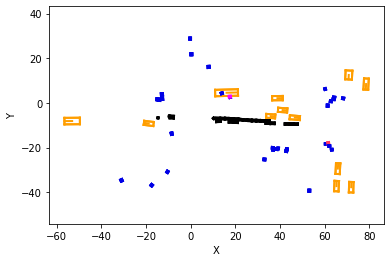

In [11]:
_, boxes, _ = nusc.get_sample_data(my_sample['data']['RADAR_FRONT'], BoxVisibility.ANY,
                                   use_flat_vehicle_coordinates=True)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.axis('equal')
print(len(boxes))
print(boxes[0])
print(boxes[0].token)
for box in boxes:
    c = np.array(NuScenesExplorer.get_color(box.name)) / 255.0
    box.render(ax, view=np.eye(4), colors=(c, c, c))

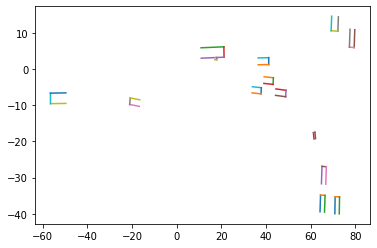

In [12]:
# box = boxes[41]
for box in boxes:
    category_name = box.name
    if ('cone' in category_name or 
        'barrier' in category_name or 
        'pedestrian' in category_name):
        continue
    bottom_corners = view_points(box.corners(), np.eye(3), False)[:2, [7, 3, 2, 6]]
    bottom_corners = bottom_corners.T
    for i in range(3):
        plt.plot([bottom_corners[i][0], bottom_corners[i+1][0]], 
                [bottom_corners[i][1], bottom_corners[i+1][1]])

In [13]:
conners = view_points(box.corners(), np.eye(3), False)

print(conners.shape)
conners

(3, 8)


array([[13.25091512, 15.24084903, 15.24084903, 13.25091512, 13.24560967,
        15.23554359, 15.23554359, 13.24560967],
       [-6.6562533 , -6.67247118, -6.67247118, -6.6562533 , -7.30723168,
        -7.32344956, -7.32344956, -7.30723168],
       [ 1.0895    ,  1.0895    , -0.0175    , -0.0175    ,  1.0895    ,
         1.0895    , -0.0175    , -0.0175    ]])

Data Reader Initialized
Evaluation Initialized


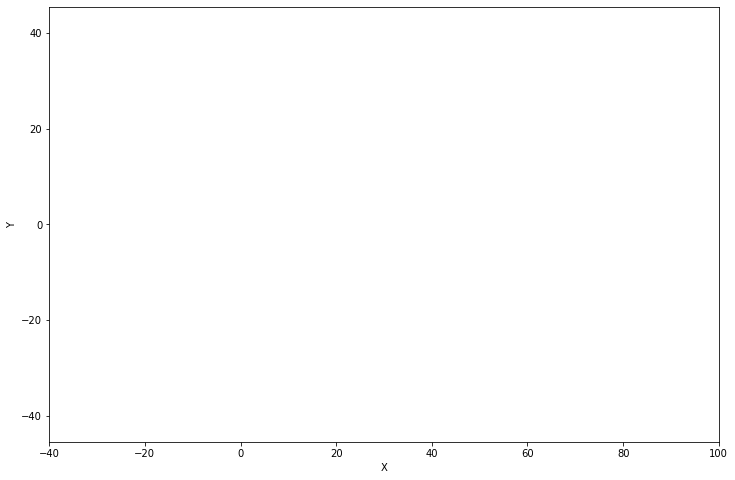

In [14]:
dr = data_ingest.DataReader(version='v1.0-mini', dataroot='/datasets/nuscenes', verbose=False)
eval = evaluation.Evaluation()

In [15]:
start = time.time()
pc_lidar, color_lidar, pose = dr.get_pointcloud('LIDAR_TOP')
pc_radar_f, color_radar_f, pose = dr.get_pointcloud('RADAR_FRONT')
pc_radar_fl, color_radar_fl, pose = dr.get_pointcloud('RADAR_FRONT_LEFT')
pc_radar_fr, color_radar_fr, pose = dr.get_pointcloud('RADAR_FRONT_RIGHT')
pc_radar_bl, color_radar_bl, pose = dr.get_pointcloud('RADAR_BACK_LEFT')
pc_radar_br, color_radar_br, pose = dr.get_pointcloud('RADAR_BACK_RIGHT')
boxes = dr.get_boxes('LIDAR_TOP')
# go to next sample
dr.next_sample()

# grid = preproc.getRadarGrid(pc, pose)
# preproc.addGrid2File()
points_lidar = pc_lidar.points
points_radar = np.c_[(pc_radar_f.points, pc_radar_fl.points, 
                      pc_radar_fr.points, pc_radar_bl.points, 
                      pc_radar_br.points)]
eval.plot_pointcloud(points_lidar, 'c', 0.3, '.')
eval.plot_pointcloud(points_radar, 'm', 5, 'D')
eval.plot_boxes(boxes)
# eval.plotGrid(grid)
# eval.plotTrajectory(pose)
eval.draw()

print(points_radar.shape)
points_radar_with_anno = dr.points_with_anno(points_radar, boxes)
print(points_radar_with_anno.shape)
print(points_radar_with_anno[-1, :])

end = time.time()
print("Time per frame: {:1.4f}s".format(end - start))

/Users/wangtao/work/github/nuRadarScenes/eval/evaluation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.ax = self.fig.add_subplot(111)
/Users/wangtao/work/github/nuRadarScenes/eval/evaluation.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.ax = self.fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

(18, 444)
(19, 444)
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [45]:
np.set_printoptions(suppress=True)
points_radar_filter = np.squeeze(points_radar_with_anno[:, np.where(points_radar_with_anno[-1] == 1)])
print(points_radar_filter.shape)
print(points_radar_filter)

(19, 31)
[[ 11.19903726  11.40043211  11.99763632  11.5934494   12.59483957
   12.99693209  14.19622646  14.5997143   16.59621146  17.40179182
   17.39271612  18.99549928  19.39130768  20.39688663  34.42961346
   35.43519241  36.8051658   39.81980826  40.82119843  70.97144414
   71.3707451   72.17493206  77.58885566  79.17838006 -17.96525019
  -18.02369565 -17.25427026 -17.1864291  -17.5583707  -52.9215017
  -54.94403041]
 [  3.72720459   3.32790506   4.12999453   5.32859124   4.93208424
    4.33348425   4.53767162   3.53907397   4.54604918   2.94885155
    5.54883561   4.75442534   5.95581457   4.35931507  -4.99175864
   -6.58825815   2.01657616  -2.17292622  -2.56943323  11.73589797
   11.93729283  10.74009286   6.75896672   9.76453351  -8.82170258
   -9.41884866  -8.66897144  -9.66666758 -10.09288256  -8.88918488
   -8.62578913]
 [  0.5          0.5          0.5          0.5          0.5
    0.5          0.5          0.5          0.5          0.5
    0.5          0.5          0.5   

In [60]:
# np.save('points_radar_filter.npy', points_radar_filter)
f = open('points_radar_filter.csv','a')
np.savetxt(f, points_radar_filter.T, delimiter=',', fmt='%.2f')
f.close()